# EDA of Amazon Electronics Data with Pyspark and Spark SQL

- This Jupyter Notebook demonstrates some querying, cleaning, and wrangling using PySpark and Spark SQL. 
- Both methods can query the data and have no differences in results and performance.
- The data was obtained from the Huggingface Repository.
-  An ETL process was used to obtain, transform, and load the data.

# Setup

In [1]:
from datasets import load_dataset
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (StructType, StructField, StringType, DoubleType, LongType, ArrayType, BooleanType)
from pyspark import StorageLevel
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

```
# Obtain the data from the Huggingface Repository
reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Electronics", trust_remote_code=True)
meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Electronics", split="full", trust_remote_code=True)
reviews = reviews["full"]

```
# Find the number of rows and columns in the data
print(reviews.shape)
print(meta.shape)

- The reviews data contains over 43 million rows and 10 columns, while the meta data contains around 1.6 million rows and 16 columns.
- Pandas is unsuitable for manipulation of datasets of this size, so distributed computing methods like PySpark has to be used instead.
- The data will be converted to Parquet format, which is efficient for storage and processing. PySpark doesn't not seem to work directly with the datasets in this case, so the conversion in file type is required.

```
import shutil
import os

# Save to Parquet (temporary folder)
reviews_path = "temp_reviews_parquet"
meta_path = "temp_meta_parquet"

reviews.to_parquet(reviews_path)
meta.to_parquet(meta_path)

# Create a SparkSession

In [2]:
# Rename to localhost
import os
os.environ["SPARK_LOCAL_HOSTNAME"] = "localhost"

In [3]:
# Create the SparkSession
spark = SparkSession.builder \
    .appName('amazon_electronics_data') \
    .config('spark.driver.memory', '16g') \
    .getOrCreate()
spark

- A SparkSession needs to be created before further work with PySpark can be done. 
- Since the data is around 10 gb in size, Spark's default 1gb of memory is insufficient and queries would not run.
- 16gb of memory is manually set instead.

In [4]:
# Display Memory setting
spark.sparkContext.getConf().get("spark.driver.memory")

'16g'

## Reviews Data

In [5]:
# Read the Parquet file
reviews = spark.read.parquet("data/temp_reviews_parquet")

# Create the Spark Table and Temp View for querying with Pyspark API and Spark SQL
reviews.createOrReplaceTempView('reviews')
reviews = spark.table('reviews')

- The data is read successfully. 
- A table and temporary view were created to run queries.

### Schema

In [6]:
# Print Reviews Schema
reviews.printSchema()

root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



- This data is on the user reviews of the products.
- The asin and parent_asin represent product identifiers.
- Some products have some minor differences (likely in options like size or color).

In [7]:
# Create the Spark Table and Temp View for querying with Pyspark API and Spark SQL
reviews.createOrReplaceTempView('reviews')
reviews = spark.table('reviews')

- Queries can be run using Spark SQL or Pyspark API.
- There is no difference in performance and results, but queries will be written using for both methods for practice and demonstration.

### Show the First 10 Rows of the Data

In [8]:
# With Pyspark API
reviews.limit(10).toPandas()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,"[(IMAGE, https://m.media-amazon.com/images/I/7...",B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True
5,5.0,Great Fan! I’m a FAN!,"Light weight, quiet and totally awesome!!! It ...",[],B072DSHKCH,B07CML419K,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1637522881041,0,True
6,5.0,solid sound for the price,Update 2-they sent a new warranty replacement....,[],B07BHHB5RH,B07BHHB5RH,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1565130879386,0,True
7,5.0,Love the headphones - great range,These are fantastic headphones and I love that...,[],B07BND376H,B09S6Y5BRG,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1541356831659,9,True
8,5.0,Five Stars,pretty good for the price.,[],B002HWRZ2K,B01LW71IBJ,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1456772571000,0,True
9,5.0,BUY THIS THANG,yes.. so good. just buy it. my favorite featu...,[],B00WK47VEW,B017T99JPG,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1456772365000,0,True


```
# With Spark SQL
spark.sql("""
SELECT *
FROM reviews
LIMIT 10
""").toPandas()

### Create a datetime column

- The timestamp column is in unix time with milliseconds.
- This is far less interpretable than something like datetime.
- A datetime column would be better and more interpretable.

In [9]:
# Add the datetime column then update the table
reviews = spark.table("reviews").withColumn("datetime", F.from_unixtime(F.col("timestamp") / 1000))

# Cache the data and trigger it
# Caching appears to take longer than running all of the queries so it will not be used.
#reviews.persist(StorageLevel.DISK_ONLY)
#reviews.count() 

# Update the view
reviews.createOrReplaceTempView("reviews")

### Summary Statistics

In [10]:
# Compute and make a table of the summary statistics with PySpark API
reviews\
.select('rating', 'helpful_vote')\
.summary('count', 'mean', 'stddev', 'min', '25%', '50%', '75%', 'max')\
.toPandas()

,summary,rating,helpful_vote
0,count,43886944,43886944
1,mean,4.099233772121385,1.0903363423983223
2,stddev,1.4123304685968932,22.575534823738767
3,min,0.0,-4
4,25%,4.0,0
5,50%,5.0,0
6,75%,5.0,0
7,max,5.0,46841


```
# Summary Statistics with Spark SQL
spark.sql("""
SELECT
  COUNT(rating) AS rating_count,
  AVG(rating) AS rating_mean,
  STDDEV(rating) AS rating_stddev,
  MIN(rating) AS rating_min,
  PERCENTILE(rating, 0.25) AS rating_25,
  PERCENTILE(rating, 0.5) AS rating_50,
  PERCENTILE(rating, 0.75) AS rating_75,
  MAX(rating) AS rating_max,
  
  COUNT(helpful_vote) AS helpful_vote_count,
  AVG(helpful_vote) AS helpful_vote_mean,
  STDDEV(helpful_vote) AS helpful_vote_stddev,
  MIN(helpful_vote) AS helpful_vote_min,
  PERCENTILE(helpful_vote, 0.25) AS helpful_vote_25,
  PERCENTILE(helpful_vote, 0.5) AS helpful_vote_50,
  PERCENTILE(helpful_vote, 0.75) AS helpful_vote_75,
  MAX(helpful_vote) AS helpful_vote_max
FROM reviews
""").toPandas()

- The areas of interest are the min rating of 0.0 and the min helpful_vote of -4.
- The ratings of 0.0 should be incorrect as Amazon ratings go from 1 to 5. Amazon used to have not helpful votes, but later took out that feature for their product user reviews. That -4 may be from reviews during that time period.

### Handling Missing Values

In [11]:
# Find the number of Missing Values using Pyspark API
reviews\
.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(f"{c}_nulls") 
    for c in reviews.columns
])\
.toPandas()

,rating_nulls,title_nulls,text_nulls,images_nulls,asin_nulls,parent_asin_nulls,user_id_nulls,timestamp_nulls,helpful_vote_nulls,verified_purchase_nulls,datetime_nulls
0,0,0,0,0,0,0,0,0,0,0,0


```
# Handle Missing Values using Spark SQL
# Set the column names
cols = reviews.columns

# Generate SQL snippet for each column
null_checks = ",\n  ".join(
    [f"SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS `{c}_nulls`" for c in cols]
)

# Create the query
query = f"""
SELECT 
  {null_checks}
FROM reviews
"""

# Run the query
spark.sql(query).toPandas()

There are no null values in the reviews data and no further work is needed here.

### Unique Value Counts by Column

In [12]:
# Find the number Unique Values using Pyspark API
reviews\
.select([
    F.countDistinct(c).alias(f"{c}_unique") 
    for c in reviews.columns
])\
.toPandas()

,rating_unique,title_unique,text_unique,images_unique,asin_unique,parent_asin_unique,user_id_unique,timestamp_unique,helpful_vote_unique,verified_purchase_unique,datetime_unique
0,6,19258533,38250600,1987253,1946161,1609860,18286191,42534478,2102,2,39949939


```
# Find Unique Values using Spark SQL
uniques = ",\n  ".join(
    [f"COUNT(DISTINCT {c}) AS `{c}_unique`" for c in cols]
)

# Create the query
query = f"""
SELECT 
  {uniques}
FROM reviews
"""

# Run the query
spark.sql(query).toPandas()

- There are 6 unique values for ratings which matches our previous finding of ratings being from 0.0 to 5.0. The only problematic value here is the 0.0.
- There are 38 million unique values for 'text,' which represents the bodies for reviews. Given that the data has around 43 million observations, around 5 million reviews have the same text. If we were to check the reviews, we may find that they are short and generally applicable such as 'Good.'
- The difference between 'asin' and 'parent_asin' is around 300,000. This value represents the number of products that appear to be the same but have different options like a shirt having different color options.
- The number of unique verified purchases looks correct.

### Verified Purchases by Rating

In [13]:
# Find Ratings by Verified Purchases using PySpark API
reviews\
.groupBy("rating")\
.agg(
    F.sum(F.when(F.col("verified_purchase") == "true", 1).otherwise(0)).alias("Number of Verified Purchases"),
    F.sum(F.when(F.col("verified_purchase") == "false", 1).otherwise(0)).alias("Number of Non-Verified Purchases")
)\
.orderBy(F.col("rating").desc())\
.toPandas()

,rating,Number of Verified Purchases,Number of Non-Verified Purchases
0,5.0,26044266,1785482
1,4.0,5044312,513413
2,3.0,2625915,257150
3,2.0,2028015,229589
4,1.0,4804374,554426
5,0.0,2,0


```
# Find Ratings by Verified Purchases using Spark SQL
spark.sql("""
SELECT 
    rating, 
    SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
    SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
GROUP BY rating
ORDER BY rating DESC
""").toPandas()

- From the summary statistics table, there were 0.0 ratings listed for the minimum ratings.
- Given that there are only 2 of them in the data and Amazon ratings range from only 1 to 5, these instances are probably errors in data entry. 

### Handling the Abnormal Ratings

In [14]:
# Check the reviews with ratings of 0.0 using PySpark API
reviews\
.filter(F.col('rating') == 0.0)\
.select('rating', 'title', 'text', 'parent_asin', 'user_id')\
.toPandas()

,rating,title,text,parent_asin,user_id
0,0.0,NOT UNIVERSAL,Didn't work for my device.,B09Z6Q2MLC,AHCTFZB5JDOEM6GKBWF4PDEXMCPA
1,0.0,One Star,I need a replacement the unit was damaged an y...,B01F3ENAOU,AG5AKJ4EROK2F6BD4SCQVZ7WP7KQ


```
# Check the reviews with ratings of 0.0 using Spark SQL
spark.sql("""
SELECT rating, title, text, parent_asin, user_id
FROM reviews
WHERE rating = 0.0
""").toPandas()

- From the title and text, the reviews appear to have negative sentiment with the second one having a title of 'One Star.'
- Since the ratings were mistakenly entered as 0.0, they should be changed to 1.0.

In [15]:
# Change those ratings to 1.0 and update the table
reviews = reviews.withColumn(
    "rating",
    F.when(F.col("rating") == 0.0, 1.0).otherwise(F.col("rating"))
)

# Update the View for SparkSQL
reviews.createOrReplaceTempView("reviews")

### Handling Negative Helpful Votes

In [16]:
# With PySpark API
reviews\
.filter(F.col('helpful_vote') < 0)\
.orderBy('datetime')\
.toPandas()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime
0,5.0,Secure source of power for charging station.,"It's so helpful in charging, very well made wi...",[],B078162HNC,B078162HNC,AFGXFHGZ7NVPJNGQLLIACS2IUYXQ,1547336082365,-1,True,2019-01-12 16:34:42
1,5.0,Excellent Ranger Extender!!! Easy to use. Easy...,I have had a previous range extender and it wa...,[],B082X3H6P9,B082X3H6P9,AEVZGLYSS3CBRF7KAO3ZDKZPFMCQ,1589208570253,-4,True,2020-05-11 07:49:30
2,5.0,Wow. Stunning.,"Or, maybe i'm easy to please.<br /><br />I rec...",[],B08CVQ5SD9,B09M8DYH1B,AGCSSPVU3FJ7IOQ5T7R7RDP5IG7Q,1619730920197,-2,True,2021-04-29 14:15:20
3,5.0,Very Handy!,Just what I needed for coding on my laptop. It...,[],B084GFMGN1,B0B2RK874T,AHFWJG5A5X2Z6HWU6YM4ZTO5BVCA,1625355873555,-1,True,2021-07-03 16:44:33


```
# With Spark SQL
spark.sql("""
SELECT *
FROM reviews
WHERE helpful_vote <0
ORDER BY datetime
""").toPandas()

- Amazon used to have a 'not helpful vote' option, but that was later removed. There is no source that can be cited on the specific date, so this can't be handled in a more targeted manner.
- The values will simply be changed to 0. 

In [17]:
# Change those helpful votes to 0 and update the reviews table
reviews = reviews.withColumn(
    "helpful_vote",
    F.when(F.col("helpful_vote") < 0, 0).otherwise(F.col("helpful_vote"))
)

# Update the View for SparkSQL
reviews.createOrReplaceTempView("reviews")

### Number of Purchases

#### Verified Purchases

In [18]:
# With Pyspark API
reviews.select(
    F.sum(F.when(F.col('verified_purchase') == True, 1).otherwise(0))
        .alias('Number of Verified Purchases'),
    F.sum(F.when(F.col('verified_purchase') == False, 1).otherwise(0))
        .alias('Number of Non-Verified Purchases')
).toPandas()

,Number of Verified Purchases,Number of Non-Verified Purchases
0,40546884,3340060


```
# With Spark SQL
spark.sql("""
SELECT 
SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
""").show()

The number of non-verified purchases is around 10% that of the number of verified purchases.

#### Most Helpful Verified Reviews

In [19]:
# With Pyspark API
reviews\
.filter(
    (F.col('helpful_vote') > 0) 
    & 
    (F.col('verified_purchase') == 'true')
)\
.select(
    'parent_asin',
    'rating', 
    'title',
    'text',
    'verified_purchase',
    'helpful_vote'
)\
.orderBy('helpful_vote', ascending=False)\
.limit(15)\
.toPandas()

,parent_asin,rating,title,text,verified_purchase,helpful_vote
0,B010BWYDYA,5.0,Why and how the Kindle changes everything,"This is less a ""pros and cons"" review than a h...",True,46841
1,B075X8471B,5.0,What I once thought was silly is now a good th...,"Earlier this month, my TV entertainment includ...",True,32948
2,B00CX5P8FC,5.0,This box is a GAME CHANGER for on demand conte...,I am not a casual user of on-demand content an...,True,26331
3,B00154JDAI,1.0,BEWARE of the SIGNIFICANT DIFFERENCES between ...,I was DELIGHTED to upgrade my Kindle 1 to K2.....,True,24261
4,B07PHQ93TV,4.0,Not going to blow smoke...,I see so many people on here who are technolog...,True,18501
5,B01K8B8YA8,5.0,The Smartest of Them All!!! (Check out the vid...,[[VIDEOID:c05af0259c5236d5d0d0d5dea9bd875a]] H...,True,18147
6,B007OZNZQ0,5.0,Amazing new Kindle is nearly perfect except fo...,"So far, I love my new Paperwhite Kindle. I've ...",True,16478
7,B008GG93YE,4.0,New Kindle Buyer? Thinking about Nook? Read on...,I got my first Kindle. This is a nice ebook re...,True,15169
8,B09KQC7Z4S,5.0,I give it five stars. My wife hates them ...,I give it five stars. My wife hates them she w...,True,15074
9,B0BWD4WGJB,2.0,One major flaw.,"I bought this to use as a baby monitor, thinki...",True,14647


```
# With Spark SQL
spark.sql("""
SELECT parent_asin, rating, title, text, verified_purchase, helpfuL_vote
FROM reviews
WHERE helpful_vote > 0 AND verified_purchase = 'true'
ORDER BY helpful_vote DESC
LIMIT 15
""").toPandas()

- The most helpful product reviews with verified purchases tend to have high (4 or 5) ratings.
- Most of them are for different products.
- Those Helpful Vote counts above 18,000 are likely outliers.

#### Most Helpful Non-Verified Reviews

In [20]:
# With Pyspark API
reviews\
.filter(
    (F.col('helpful_vote') > 0) 
    & 
    (F.col('verified_purchase') == 'false')
)\
.select(
    'parent_asin',
    'rating', 
    'title',
    'text',
    'verified_purchase',
    'helpful_vote'
)\
.orderBy('helpful_vote', ascending=False)\
.limit(15)\
.toPandas()

,parent_asin,rating,title,text,verified_purchase,helpful_vote
0,B000I1X6PM,3.0,Rift in the time-space continuum,"The minute I plugged this cable in, I knew som...",False,12587
1,B00LWHUBPO,5.0,Detailed Review of the Kindle,"As has been the case for years, Amazon sloooow...",False,10579
2,B08RLW7918,1.0,Spy alert!!!!!,"The camera video quality is definitely good, b...",False,9531
3,B000J36XR2,1.0,I have only a little time...,We live underground. We speak with our hands. ...,False,8957
4,B07ZPC9QD4,4.0,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t...",False,8626
5,B08M8Y6473,3.0,"The Pros, Cons and Oks for Fitbit Versa 2 (HR).",Pros:__________<br />• It’s very comfortable. ...,False,8608
6,B009T3EYHO,4.0,A very good computer with a few drawbacks at a...,***Updates To My Review At The End***<br /><br...,False,8384
7,B07RJZPTLX,4.0,"The Pros, Cons and Oks for Kindle Oasis (HR).","Pros:__________<br />• It’s small, provides b...",False,7977
8,B00L403O8U,5.0,Financing Available!,I was able to purchase this amazing television...,False,7660
9,B0BVY4JVNG,1.0,Only half the equation. The other half will co...,I just received this today.<br /><br />I thoug...,False,7632


```
# With Spark SQL
spark.sql("""
SELECT parent_asin, rating, title, text, verified_purchase, helpfuL_vote
FROM reviews
WHERE helpful_vote > 0 AND verified_purchase = 'false'
ORDER BY helpful_vote DESC
LIMIT 15
""").toPandas()

- Reviews that aren't verified purchases tend to have much fewer helpful votes than those that do.
- The top 15 Helpful Vote count for the verified purchases are around double those with non-verified purchases, excluding potential outliers.

### Verified purchases for each rating

In [21]:
# With Pyspark API
reviews\
.groupBy('rating')\
.agg(
    F.sum(F.when(F.col('verified_purchase') == True, 1).otherwise(0))
        .alias('Number of Verified Purchases'),
    F.sum(F.when(F.col('verified_purchase') == False, 1).otherwise(0))
        .alias('Number of Non-Verified Purchases')
)\
.orderBy('rating', ascending=False)\
.toPandas()

,rating,Number of Verified Purchases,Number of Non-Verified Purchases
0,5.0,26044266,1785482
1,4.0,5044312,513413
2,3.0,2625915,257150
3,2.0,2028015,229589
4,1.0,4804376,554426


```
# With Spark SQL
spark.sql("""
SELECT 
    rating, 
    SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
    SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
GROUP BY rating
ORDER BY rating DESC
""").toPandas()

- Ratings between 2 to 4 have similar numbers if we were to account for the proportion of data.
- The number of non-verified purchases are around 10% the number of verified purchases for those ratings.
- There tend to be more ratings of 5 for verified purchases and more ratings of 1 for non-verified purchases.
- As expected, the ratings of 1 and 5 are where the difference lie.
- The 2 greatest concerns with reviews are review bombing and review inflation. For non-verified purchases, ratings of 5 are much higher than others, and review inflation is worth looking into.

### 2023 Rating Count

In [22]:
# With PySpark API
reviews\
.filter(F.year("datetime") == 2023) \
.groupBy("rating") \
.agg(
    F.count("*").alias("num_ratings_2023"),
    F.sum(F.when(F.col("verified_purchase") == "true", 1).otherwise(0)).alias("Number of Verified Purchases"),
    F.sum(F.when(F.col("verified_purchase") == "false", 1).otherwise(0)).alias("Number of Non-Verified Purchases")
)\
.orderBy("num_ratings_2023", ascending=False) \
.toPandas()

,rating,num_ratings_2023,Number of Verified Purchases,Number of Non-Verified Purchases
0,5.0,1190958,1054998,135960
1,1.0,289692,268795,20897
2,4.0,198503,161945,36558
3,3.0,124327,109692,14635
4,2.0,105836,96773,9063


```
# With Spark SQL
spark.sql("""
SELECT 
    rating,
    COUNT(*) AS num_ratings_2023,
    SUM(CASE WHEN verified_purchase = 'true' THEN 1 ELSE 0 END) AS `Number of Verified Purchases`,
    SUM(CASE WHEN verified_purchase = 'false' THEN 1 ELSE 0 END) AS `Number of Non-Verified Purchases`
FROM reviews
WHERE YEAR(datetime) = 2023
GROUP BY rating
ORDER BY num_ratings_2023 DESC
""").toPandas()

- The number of 5.0 ratings is significantly higher than the numbers of other ratings.
- The second rating with the highest count is 1.0.
- Amazon product reviewers tend to gravitate to the extremes when rating Electronics products.
- The numbers could reflect how Amazon screens and removes fake reviews, showing that their focus is on 1 star reviews instead of 5 star reviews.
- Alternatively, it could also mean that users are more likely to leave reviews on (Electronics) products that they are extremely pleased with.

## Meta Data

### Schema

In [23]:
# Read the Parquet file
meta = spark.read.parquet("data/temp_meta_parquet")

# Print Meta Schema
meta.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: string (nullable = true)
 |-- images: struct (nullable = true)
 |    |-- hi_res: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- large: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- thumb: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- variant: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- videos: struct (nullable = true)
 |    |-- title: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- url: array (nullable = true)
 |    |    |-- element

- This data represents product metadata.
- It contains information on the product, name, features, and seller.
- Subtitle and author are rather strange for Electronics products and warrant investigation.

In [24]:
# Create the Spark Table and Temp View for querying with Pyspark API and Spark SQL
meta.createOrReplaceTempView('meta')
meta = spark.table('meta')

### Show the First 10 Rows of the Data

In [25]:
# With Pyspark API
meta.limit(10).toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Electronics,FS-1051 FATSHARK TELEPORTER V3 HEADSET,3.5,6,[],[Teleporter V3 The “Teleporter V3” kit sets a ...,None,"([None], [https://m.media-amazon.com/images/I/...","([], [], [])",Fat Shark,"[Electronics, Television & Video, Video Glasses]","{""Date First Available"": ""August 2, 2014"", ""Ma...",B00MCW7G9M,None,None,None
1,All Electronics,Ce-H22B12-S1 4Kx2K Hdmi 4Port,5.0,1,"[UPC: 662774021904, Weight: 0.600 lbs]",[HDMI In - HDMI Out],None,([https://m.media-amazon.com/images/I/51qxU4Zd...,"([], [], [])",SIIG,"[Electronics, Television & Video, Accessories,...","{""Product Dimensions"": ""0.83 x 4.17 x 2.05 inc...",B00YT6XQSE,None,None,None
2,Computers,Digi-Tatoo Decal Skin Compatible With MacBook ...,4.5,246,[WARNING: Please IDENTIFY MODEL NUMBER on the ...,[],19.99,([https://m.media-amazon.com/images/I/61RPxmi+...,"([AL 2Sides Video, MacBook Protective Skin, AR...",Digi-Tatoo,"[Electronics, Computers & Accessories, Laptop ...","{""Brand"": ""Digi-Tatoo"", ""Color"": ""Fresh Marble...",B07SM135LS,None,None,None
3,AMAZON FASHION,NotoCity Compatible with Vivoactive 4 band 22m...,4.5,233,[☛NotoCity 22mm band is designed for Vivoactiv...,[],9.99,([https://m.media-amazon.com/images/I/51ajKKbi...,"([], [], [])",NotoCity,"[Electronics, Wearable Technology, Clips, Arm ...","{""Date First Available"": ""May 29, 2020"", ""Manu...",B089CNGZCW,None,None,None
4,Cell Phones & Accessories,Motorola Droid X Essentials Combo Pack,3.8,64,"[New Droid X Essentials Combo Pack, Exclusive ...",[all Genuine High Quality Motorola Made Access...,14.99,"([None, None, None, None, None], [https://m.me...","([], [], [])",Verizon,"[Electronics, Computers & Accessories, Compute...","{""Product Dimensions"": ""11.6 x 6.9 x 3.1 inche...",B004E2Z88O,None,None,None
5,Sports & Outdoors,Raymarine Wi-Fish DownVision Blackbox Sonar wi...,3.5,25,[Black box Wi-Fi CHIRP DownVision sonar module...,[Transform your smartphone into a powerful CHI...,None,([https://m.media-amazon.com/images/I/719G-0+W...,"([], [], [])",Raymarine,"[Electronics, Car & Vehicle Electronics, Marin...","{""Item Package Dimensions L x W x H"": ""9.3 x 8...",B00TX536EK,None,None,None
6,Cell Phones & Accessories,"QGHXO Band for Garmin Vivofit 4, Soft Silicone...",4.4,707,[Personalized Your Garmin Vivofit 4 Activity T...,"[Compatibility, Custom designed for your preci...",14.89,([https://m.media-amazon.com/images/I/61J-V53D...,"([], [], [])",QGHXO,"[Electronics, Wearable Technology, Arm & Wrist...","{""Package Dimensions"": ""6.85 x 4.37 x 1.1 inch...",B07BJ7ZZL7,None,None,None
7,Industrial & Scientific,Protech iPhone 4 microscope 60X Lens with illu...,3.8,6,[iPhone 4 Microscope with White 2-LED and Dete...,[This accessory will convert your iPhone 4 int...,None,"([None, None, None, None, None, None, None, No...","([], [], [])",ProTech,"[Electronics, Camera & Photo, Binoculars & Sco...","{""Light Source Type"": ""LED"", ""Color"": ""Blue,Wh...",B005G99O2U,None,None,None
8,Computers,MOSISO Plastic Hard Shell Case & Keyboard Cove...,5.0,2,[],[],None,([https://m.media-amazon.com/images/I/71XrfOMK...,"([], [], [])",MOSISO,"[Electronics, Headphones, Earbuds & Accessorie...","{""Brand"": ""MOSISO"", ""Item Weight"": ""8 ounces"",...",B01MCZP7RF,None,None,None
9,None,"Fishfinder, Depth Finder Poly Sun Cover for 3""...",4.4,86,"[Made of poly material, Available in black, Dr...",[Affordable and convenient way to cover your s...,10.99,"([None, None, None, None], [https://m.media-am...","([Unboxing Gamin Vivid , Garmin Striker Vivid ...",Westlake Market,"[Electronics, Car & Vehicle Electronics, Marin...","{""Item Package Dimensions L x W x H"": ""7.32 x ...",B00R6R82HS,None,None,None


```
# With Spark SQL
spark.sql("""
SELECT *
FROM meta
LIMIT 10
""").toPandas()

- There's a lot of nulls for the last 3 columns: bought_together, subtitle, and author.
- The last 2 columns also appear out of place for an electronics products dataset.

### Summary Statistics

In [26]:
# Summary Statistics with PySpark API
meta\
.select('average_rating', 'rating_number', 'price')\
.summary('count', 'mean', 'stddev', 'min', '25%', '50%', '75%', 'max')\
.toPandas()

,summary,average_rating,rating_number,price
0,count,1610012,1610012,1610012
1,mean,4.0085408680183505,180.4833075778317,96.45767498849601
2,stddev,0.8331378499766278,2543.9800659979737,319.1737878683855
3,min,1.0,1,0.0
4,25%,3.6,3,11.99
5,50%,4.2,12,22.9
6,75%,4.6,49,59.99
7,max,5.0,1034896,—


```
# Summary Statistics with Spark SQL
spark.sql("""
SELECT
  COUNT(average_rating) AS average_rating_count,
  AVG(average_rating) AS average_rating_mean,
  STDDEV(average_rating) AS average_rating_stddev,
  MIN(average_rating) AS average_rating_min,
  PERCENTILE_APPROX(average_rating, 0.25) AS average_rating_25,
  PERCENTILE_APPROX(average_rating, 0.5) AS average_rating_50,
  PERCENTILE_APPROX(average_rating, 0.75) AS average_rating_75,
  MAX(average_rating) AS average_rating_max,

  COUNT(rating_number) AS rating_number_count,
  AVG(rating_number) AS rating_number_mean,
  STDDEV(rating_number) AS rating_number_stddev,
  MIN(rating_number) AS rating_number_min,
  PERCENTILE_APPROX(rating_number, 0.25) AS rating_number_25,
  PERCENTILE_APPROX(rating_number, 0.5) AS rating_number_50,
  PERCENTILE_APPROX(rating_number, 0.75) AS rating_number_75,
  MAX(rating_number) AS rating_number_max,

  COUNT(price) AS price_count,
  AVG(price) AS price_mean,
  STDDEV(price) AS price_stddev,
  MIN(price) AS price_min,
  PERCENTILE_APPROX(price, 0.25) AS price_25,
  PERCENTILE_APPROX(price, 0.5) AS price_50,
  PERCENTILE_APPROX(price, 0.75) AS price_75,
  MAX(price) AS price_max
""").toPandas()
FROM meta

- There are 1,610,012 rows in the data.
- The Average Rating column ranges in values from 1 to 5, which is reasonable.
- Unsurprisingly, Average Ratings of exactly 5 are extreme values that probably result from having a small number of reviews.
- Most of the Average Ratings are above 3 (around 4 according to the mean).
- The Rating Number has a - for the max, which is likely do it being a string as reported in the schema. The same goes for the price.
- Most electronic products are below $60 in price.

In [27]:
# Define placeholder strings that may represent missing data
placeholders = ['None', 'none', 'N/A', 'n/a', 'null', 'NULL', '']

# Convert placeholders to nulls
for c in meta.schema.fields:
    if isinstance(c.dataType, StringType):
        meta = meta.withColumn(
            c.name,
            F.when(F.col(c.name).isin(placeholders), None).otherwise(F.col(c.name))
        )

# Cast the price in the meta table
meta = meta.withColumn("price", F.expr("try_cast(price AS double)"))

# Update the View for SparkSql 
meta.createOrReplaceTempView("meta")

### Handling Missing Values

In [28]:
# Find Missing Values with Pyspark API
meta.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(f"{c}") 
    for c in meta.columns
]).toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,106334,98,0,0,0,0,1083563,0,0,9570,0,0,0,1610012,1609161,1609536


```
# Find Missing Values with Spark SQL
# Set the column names
cols = meta.columns

# Generate SQL snippet for each column
null_checks = ",\n  ".join(
    [f"SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS `{c}`" for c in cols]
)

# Create the query
query = f"""
SELECT 
  {null_checks}
FROM meta
"""

# Run the query
spark.sql(query).toPandas()

- The number of nulls look good for most of the data.
- The store having nulls might be related to third party sellers.
- main_category warrants further investigation.
- There may a general main_category that aggregates other electronics that don't fit into any specific category.
- It looks like the bought_together, subtitle, and author columns are almost, if not entirely, null.

In [29]:
# Make a table of missing and available counts for the bought_together, subtitle, and author columns using PySpark API
# Store null counts
null_counts = meta.select(
    F.sum(F.when(F.col('bought_together').isNull(), 1).otherwise(0)).alias('bought_together_nulls'),
    F.sum(F.when(F.col('subtitle').isNull(), 1).otherwise(0)).alias('subtitle_nulls'),
    F.sum(F.when(F.col('author').isNull(), 1).otherwise(0)).alias('author_nulls')
)

# Store not-null counts
not_null_counts = meta.select(
    F.sum(F.when(F.col('bought_together').isNotNull(), 1).otherwise(0)).alias('bought_together_not_nulls'),
    F.sum(F.when(F.col('subtitle').isNotNull(), 1).otherwise(0)).alias('subtitle_not_nulls'),
    F.sum(F.when(F.col('author').isNotNull(), 1).otherwise(0)).alias('author_not_nulls')
)

# Join both results with crossJoin
null_counts.crossJoin(not_null_counts).toPandas()

,bought_together_nulls,subtitle_nulls,author_nulls,bought_together_not_nulls,subtitle_not_nulls,author_not_nulls
0,1610012,1609161,1609536,0,851,476


```
# # Make a table of missing and available counts for the bought_together, subtitle, and author columns using SparkSQL
# Use Common Table Expressions to store the Null and Not-Null queries, then join them
spark.sql("""
WITH null_counts AS (
  SELECT 
    SUM(CASE WHEN bought_together IS NULL THEN 1 ELSE 0 END) AS bought_together_nulls,
    SUM(CASE WHEN subtitle IS NULL THEN 1 ELSE 0 END) AS subtitle_nulls,
    SUM(CASE WHEN author IS NULL THEN 1 ELSE 0 END) AS author_nulls
  FROM meta
),
not_null_counts AS (
  SELECT 
    SUM(CASE WHEN bought_together IS NOT NULL THEN 1 ELSE 0 END) AS bought_together_not_nulls,
    SUM(CASE WHEN subtitle IS NOT NULL THEN 1 ELSE 0 END) AS subtitle_not_nulls,
    SUM(CASE WHEN author IS NOT NULL THEN 1 ELSE 0 END) AS author_not_nulls
  FROM meta
)

SELECT *
FROM null_counts
JOIN not_null_counts
""").toPandas()

- It looks like the table is mostly populated with null values for these columns.
- Bought_together in particular is entirely null and should be removed entirely.

#### Investigating Authors Column

In [30]:
# Show 5 products in the Books category using Pyspark API
meta\
.filter(F.col('author').isNotNull())\
.select('main_category', 'title', 'subtitle', 'categories', 'author')\
.limit(5)\
.toPandas()

,main_category,title,subtitle,categories,author
0,Books,Practical Modern Basketball (3rd Edition),3rd Edition,"[Electronics, Accessories & Supplies]",{'avatar': 'https://m.media-amazon.com/images/...
1,Books,Garmin GPSMAP 496 Qref Checklist (Qref Avionic...,"Spiral-bound – December 15, 2008","[Electronics, Car & Vehicle Electronics, Aviat...",{'avatar': 'https://m.media-amazon.com/images/...
2,Books,Sleepwalker: The Last Sandman,"Paperback – July 30, 2010","[Electronics, eBook Readers & Accessories, eBo...",{'avatar': 'https://m.media-amazon.com/images/...
3,Books,Disney Moana: Movie Theater Storybook & Movie ...,"Hardcover – October 4, 2016","[Electronics, Video Projectors]",{'avatar': 'https://m.media-amazon.com/images/...
4,Books,Estrella errante (Zodíaco) (Spanish Edition),"Paperback – October 1, 2017","[Electronics, Computers & Accessories, Compute...",{'avatar': 'https://m.media-amazon.com/images/...


```
# Show 5 products in the Books category using Spark SQL
spark.sql("""
SELECT main_category, title, subtitle, categories, author
FROM meta
WHERE author IS NOT NULL
LIMIT 5
""").toPandas()

It looks like there are books in the electronics product data. From the subtitles, some of these are physical books rather than eBooks from Kindle. Let's filter out the Books from the main_category and see what we get.

In [31]:
# Show 5 products in the Buy a Kindle category using Pyspark API
meta\
.filter(
    F.col('author').isNotNull() &
    (F.col('main_category') != 'Books')    
)\
.select('main_category', 'title', 'subtitle', 'categories', 'author')\
.limit(5)\
.toPandas()

,main_category,title,subtitle,categories,author
0,Buy a Kindle,Five Little Monkeys Storybook Treasury (A Five...,Kindle Edition,"[Electronics, Computers & Accessories, Compute...",{'avatar': 'https://m.media-amazon.com/images/...
1,Buy a Kindle,HF Antenna Accessories (Amateur Radio HF Anten...,Kindle Edition,"[Electronics, Television & Video, Accessories]",{'avatar': 'https://m.media-amazon.com/images/...
2,Buy a Kindle,An Orphan in the Snow: The heart-warming saga ...,Kindle Edition,"[Electronics, eBook Readers & Accessories, eBo...",{'avatar': 'https://m.media-amazon.com/images/...
3,Buy a Kindle,Sister Peters in Amsterdam,Kindle Edition,"[Electronics, Accessories & Supplies, Telephon...",{'avatar': 'https://m.media-amazon.com/images/...
4,Buy a Kindle,Basher Five-Two,Kindle Edition,"[Electronics, Car & Vehicle Electronics, Aviat...",{'avatar': 'https://m.media-amazon.com/images/...


```
# Show 5 products in the Buy a Kindle category using Spark SQL
spark.sql("""
SELECT main_category, title, subtitle, categories, author
FROM meta
WHERE author IS NOT NULL AND main_category != 'Books'
LIMIT 5
""").toPandas()

- It looks like there really are Kindle books in the data.
- Let's see what happens when books and Kindle products are removed from the data.

In [32]:
# Check the number missing values excluding Book and Kindle products using Pyspark API
meta\
.filter(
    F.col('author').isNotNull() &
    (F.col('main_category') != 'Books') &
    (F.col('main_category') != 'Buy a Kindle')
    
)\
.select('main_category', 'title', 'subtitle', 'categories', 'author')\
.limit(5)\
.toPandas()

,main_category,title,subtitle,categories,author


```
# Check the number missing values excluding Book and Kindle products using Spark SQL
spark.sql("""
SELECT main_category, title, subtitle, categories, author
FROM meta
WHERE author IS NOT NULL AND main_category != 'Books' AND main_category != 'Buy a Kindle'
""").toPandas()

- It appears the authors column has only values in the Books or Buy a Kindle main categories.
- Since books aren't electronics let's remove these products from the data.

#### Removing Books and Kindle eBooks

In [33]:
# Removing the targeted rows with Pyspark API
meta = meta\
.filter(
    ~F.col('main_category').isin('Books', 'Buy a Kindle') 
)

# Replace the view for SparkSql with the updated table
meta.createOrReplaceTempView("meta")

In [34]:
# Double check that the rows were removed as intended using PySpark API
meta\
.filter(
    F.col('main_category').isin('Books', 'Buy a Kindle') 
)\
.select('main_category', 'title', 'subtitle', 'categories', 'author')\
.limit(5)\
.toPandas()

,main_category,title,subtitle,categories,author


```
# Double check that the rows were removed as intended using Spark SQL
spark.sql("""
SELECT main_category, title, subtitle, categories, author
FROM meta
WHERE author IS NOT NULL AND main_category != 'Books' AND main_category != 'Buy a Kindle'
""").toPandas()

There appears to be no data after removing Books and Buy a Kindle products.

#### Remove columns

- Since they are null, it's better to remove the columns for bought_together, subtitle, and author.
- The images and videos columns aren't needed for this project and will be removed as well.

In [35]:
# Remove the bought_together, subtitle, image, and videos columns
meta = meta.drop('bought_together', 'subtitle', 'author', 'images', 'videos')
meta.createOrReplaceTempView("meta")

### Most Popular Products

In [36]:
# Find the most rated products using PySpark API
meta\
.select(
    F.col('parent_asin'),
    F.col('title'),
    F.col('rating_number'),
    F.col('main_category'),    
)\
.orderBy('rating_number', ascending=False)\
.limit(10)\
.toPandas()

,parent_asin,title,rating_number,main_category
0,B07H65KP63,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",1034896,Amazon Devices
1,B07GZFM1ZM,Fire TV Stick 4K streaming device with Alexa V...,819630,Amazon Devices
2,B07PXGQC1Q,Apple AirPods (2nd Generation) Wireless Earbud...,585624,Apple Products
3,B08F1P3BCC,Echo Dot (4th Gen) | Smart speaker with Alexa ...,584328,Amazon Devices
4,B07KTYJ769,"Amazon Smart Plug, for home automation, Works ...",542825,Amazon Devices
5,B0BGNG1294,"Amazon Basics HDMI Cable, 18Gbps High-Speed, 4...",507202,Home Audio & Theater
6,B0791TX5P5,Fire TV Stick streaming device with Alexa buil...,474536,Amazon Devices
7,B08CLNX58K,SanDisk 32GB 2-Pack Ultra MicroSDHC UHS-I Memo...,402800,Computers
8,B08WJSHSLC,Fire TV Stick (3rd Gen) with Alexa Voice Remot...,379565,Amazon Devices
9,B07HZLHPKP,"Echo Show 5 (1st Gen, 2019 release) -- Smart d...",356248,Amazon Devices


``` # Find the most rated products using SparkSQL
spark.sql("""
SELECT 
parent_asin, title, rating_number, main_category
FROM meta
ORDER BY rating_number DESC
LIMIT 10
""").toPandas()

- From the names, it's not very surprising these products are the most rated, and by proxy, the most popular on Amazon.
- Apple products, Fire, and Echo products are as popular as expected.
- The Echo Dot 3rd Gen has been discontinued, but an old page for it (https://a.co/d/eRzCkEj) shows around a million ratings and the numbers look legitimate. 

### Most Expensive Products

In [37]:
# Find the most expensive products using PySpark API
meta\
.select(
    F.col('parent_asin'),
    F.col('title'),
    F.col('price'),
    F.col('main_category'),    
)\
.orderBy('price', ascending=False)\
.limit(10)\
.toPandas()

,parent_asin,title,price,main_category
0,B01N1P1685,Panasonic PT DS20K2U - SXGA+ DLP Projector - 2...,30999.00,All Electronics
1,B08VWPYY6W,Intelligent Security Patrol Service Robot Auto...,26888.00,Industrial & Scientific
2,B0B3S78JFL,LG 97-Inch Class OLED evo Gallery Edition G2 S...,24996.99,All Electronics
3,B01NBNX2NP,Sony VPLVZ1000ES Ultra-Short Throw 4K HDR Home...,24995.00,All Electronics
4,B074Z53X99,Sony VPLVW885ES 4K HDR Laser Home Theater Vide...,23390.12,All Electronics
5,B07TS6J1DN,Wacom Intuos Small Refurbished Graphics Drawin...,21111.35,Computers
6,B01GGNKUS6,Panasonic 4K UHD 2160P LED-Backlit LCD Flat Pa...,19974.00,Computers
7,B07GM3J6SH,Sony 4K HDR Laser Home Theater Video Projector...,19458.93,All Electronics
8,B07HY8HTKR,JVC DLA-NX9 4K Home Theater Projector with 8K/...,17999.99,All Electronics
9,B00WF9GZV2,HP 5412R 92GT PoE+/4SFP+ (No PSU) v3 zl2 Switc...,17937.16,Computers


```
# Find the most expensive products using SparkSQL
spark.sql("""
SELECT 
parent_asin, title, price, main_category
FROM meta
ORDER BY price DESC
LIMIT 10
""").toPandas()

The priciest electronics products are mainly projectors. Other items include massive tvs, a high-end tablet for artists, and a network switch from HP.

### Cheapest Products

In [38]:
# Find the cheapest products using PySpark API
meta\
.select(
    F.col('parent_asin'),
    F.col('title'),
    F.col('price'),
    F.col('main_category'),    
)\
.orderBy('price', ascending=True)\
.limit(10)\
.toPandas()

,parent_asin,title,price,main_category
0,B081XZLDZT,Cute VSCO Stickers for Water Bottles 50 Pcs Vi...,NaN,Computers
1,B08DWT6XM5,"Elejolie Vertical Holder for Laptop,Surface Ve...",NaN,Office Products
2,B07H5DCZM2,Monster Truck Backdrop Car Racing Background G...,NaN,Camera & Photo
3,B00TK0UL6Y,TOOGOO(R) 10 Pcs Black 3 Pin 3.5mm x 1.3mm DC ...,NaN,Computers
4,B08B57V994,jvomk MacBook Pro 16 inch Case 2019 Release A2...,NaN,Cell Phones & Accessories
5,B010PAUNTM,Eathtek Replacement CPU Cooling Cooler Fan for...,NaN,Industrial & Scientific
6,B07C1B94TT,HDMI Female to DV-D Male Rotating ADPTR,NaN,All Electronics
7,B072XGTDL9,SharkFZ Electronics Organizer for Iphone Ipad ...,NaN,Computers
8,B015TJKV0K,SUNWAYFOTO T2C40C 4 Sections Carbon Fiber Trip...,NaN,Camera & Photo
9,B0983H2ZHJ,"picK-me Cell Phone Stand, 5 PCS Universal Pock...",NaN,All Electronics


```
# Find the cheapest products using SparkSQL
spark.sql("""
SELECT 
parent_asin, title, price, main_category
FROM meta
ORDER BY price
LIMIT 10
""").toPandas()

- There are a lot of null prices.
- There doesn't seem to be a good way to handle them other than to ignore their prices or remove them entirely.
- Imputing prices would have to be done for each product individually, which someone with a data entry role could be assigned to do.
- Let's run another query, but this time we'll remove the nulls from consideration.

In [39]:
# Find the cheapest products using PySpark API (after removing nulls)
meta\
.filter(
    F.col('price').isNotNull()
)\
.select(
    F.col('parent_asin'),
    F.col('title'),
    F.col('price'),
    F.col('main_category'),    
)\
.orderBy('price', ascending=True)\
.limit(10)\
.toPandas()

,parent_asin,title,price,main_category
0,B08CBZG2PW,[3-Pack] Webcam Cover 0.7MM Thin - Web Camera ...,0.01,Cell Phones & Accessories
1,B006K4FZIW,Elan Passport,0.01,Home Audio & Theater
2,B084ZV6MYV,"hudiemm0B 3.5mm Headphone Extension Cable, 1.5...",0.01,Sports & Outdoors
3,B0161YQEAI,Amiibo Card Animal Crossing Happy Home Design ...,0.01,Computers
4,B07BH3N7KD,"iBarbe Micro USB Cable, 6FT Charge Cable,Andro...",0.01,Industrial & Scientific
5,B09C1XKKXH,"ZTGD Adapter Cable, 20cm 90-Degree Right-Angle...",0.01,Sports & Outdoors
6,B091265SJZ,LUYANhapy9 Wired Headset Universal 3.5mm in-Ea...,0.01,All Electronics
7,B0C1J76JKL,CaseHQ Compatible AirPods PRO Case Cover [Fron...,0.01,Cell Phones & Accessories
8,B00005AR4H,Handspring Visor Edge Hard Case (Metallic Silver),0.01,All Electronics
9,B07L271L62,50 PCS careda Reusable Fastening Cable cord Ti...,0.01,Tools & Home Improvement


```
# Find the cheapest products using Spark SQL (after removing nulls)
spark.sql("""
SELECT 
parent_asin, title, price, main_category
FROM meta
WHERE price IS NOT NULL
ORDER BY price
LIMIT 10
""").toPandas()

- The prices for these products look strangely low. 
- Of course, it is possible that these prices are genuine, but they likely don't take into account something like shipping costs. 
- Sometimes sellers deliberately put low prices such as 1 cent, but charge 10s or 100s of dollars for the shipping.
- It may be better practice to use the sum of the cost of the item and the shipping cost as the price.

### Top Product Categories

In [40]:
# Find the categories with the most entries using PySpark
meta.groupBy("main_category")\
.agg(F.count("parent_asin").alias("cat_count"))\
.dropDuplicates(["main_category", "cat_count"])\
.orderBy(F.col("cat_count").desc())\
.limit(20)\
.toPandas()

,main_category,cat_count
0,Computers,418868
1,All Electronics,376435
2,Camera & Photo,223690
3,Cell Phones & Accessories,138237
4,Home Audio & Theater,106516
5,Industrial & Scientific,50555
6,Car Electronics,27332
7,Tools & Home Improvement,24042
8,Amazon Home,21299
9,Office Products,21250


```
# Find the categories with the most entries using Spark SQL
spark.sql("""
SELECT DISTINCT 
    main_category, 
    COUNT(parent_asin) AS cat_count
FROM meta
GROUP BY main_category
ORDER BY cat_count DESC
LIMIT 20
""").toPandas()

- The categories look mostly reasonable.
- Amazon Fashion and All Beauty stand out though, and may be better off removed.
- Computers, cameras, cell phones, and home audio & theatre are the most common products listed on Amazon.

### Most Liked Products

#### Highest Rated Products

In [41]:
# Find the highest rated products using PySpark API
meta\
.select(
    'title',
    'parent_asin',
    'average_rating',
    'rating_number',
    'main_category'
)\
.orderBy('average_rating', ascending=False)\
.limit(10)\
.toPandas()

,title,parent_asin,average_rating,rating_number,main_category
0,"Dell 2023 Inspiron 16 7620 2-in-1 16"" Touchscr...",B08SJJG6ZX,5.0,2,Computers
1,for iPod Touch Gen 5 - Gym Hair Don't Care - G...,B014W9EBG8,5.0,1,Cell Phones & Accessories
2,"GLS Audio 6ft Patch Cable Cords - RCA to 1/4"" ...",B0010Z383K,5.0,7,All Electronics
3,"Speaker Grill - 10"", Flat Black",B00E1P4NDA,5.0,1,Musical Instruments
4,HP 14 2020 Newest Business Laptop Computer I 1...,B08B41M4WS,5.0,1,Computers
5,Hotsmtbang Replacement Remote Control for Sams...,B075YSLRFL,5.0,1,All Electronics
6,truCELL 1400 mAh BlackBerry DX-1 Battery for B...,B005BTIKHA,5.0,2,Cell Phones & Accessories
7,Skinit Decal Gaming Skin Compatible with Xbox ...,B0BZ6Y9WZQ,5.0,1,All Electronics
8,iSee Case (TM) Cartoon Bumble Bee Silicone Ful...,B00AL5UXYM,5.0,1,Portable Audio & Accessories
9,Gator Cases GR-WH4B1221TD-12U 21-Inch Deep Sec...,B001V5JAU4,5.0,3,Home Audio & Theater


```
# Find the highest rated products using Spark SQL
spark.sql("""
SELECT 
    title,
    parent_asin,
    average_rating,
    rating_number,
    main_category
FROM meta
ORDER BY average_rating DESC
LIMIT 10
""").toPandas()

- Unsurprisingly, the products with the highest average ratings (at the maximum value of 5) have very few ratings. Something similar will probably appear for those with the lowest ratings.

#### Highest Rated Products by Average Rating

In [42]:
# Find the highest rated products using PySpark API
meta\
.filter(
    F.col('rating_number') > 1000
       )\
.select(
    'title',
    'parent_asin',
    'average_rating',
    'rating_number',
    'main_category'
)\
.orderBy('average_rating', ascending=False)\
.limit(20)\
.toPandas()

,title,parent_asin,average_rating,rating_number,main_category
0,Baymax Big Hero 6 Vinyl Decal Sticker|WHITE|Ca...,B075ZFLVYD,5.0,1073,Computers
1,SimpTronic Tech LCD Replacement for Amazon Kin...,B00N993BAA,5.0,1315,All Electronics
2,6 ft HDMI to HDMI Cable Compatible with Roku H...,B08BWSKTCV,5.0,1266,All Electronics
3,13-13.3 Inch Laptop Sleeve Case Compatible Ace...,B07F1HS944,5.0,1405,All Electronics
4,Aodyow ELKGEAR Laptop Sleeve Water Repellent C...,B07M5MYBRY,5.0,1008,All Electronics
5,SimpTronic Tech Optrix Tripod Connector for Ph...,B00FQPC23M,5.0,1117,Computers
6,Animal Monkey Zoo Sugar Decorations Cookie Cup...,B008H5UMYY,5.0,1006,Amazon Home
7,WiFi Extender Internet Signal Booster and Ampl...,B0C65RFZ5J,5.0,1033,All Electronics
8,SimpTronic Tech FORSPARK 4K HDMI Cable 33 Feet...,B07G15K1JV,5.0,1042,All Electronics
9,SimpTronic Tech GGS DSLR LCD Optical Glass Scr...,B0013LO9XO,5.0,1116,All Electronics


```
# Find the most popular products using Spark SQL
spark.sql("""
SELECT 
    title,
    parent_asin,
    average_rating,
    rating_number,
    main_category
FROM meta
ORDER BY rating_number DESC
WHERE rating_number > 1000
LIMIT 10
""").toPandas()

- The products with highest average ratings, excluding those with few reviews, tend to be the products with the most ratings such as: Fire, Echo, and Apples products.

### Highest Rated Products Excluding Amazon Devices

In [43]:
# Find the highest rated products using PySpark API, excluding Amazon products such as Fire and Echo
meta\
.filter(
    (F.col("main_category") != "Amazon Devices") &
    (~F.col("title").like("Amazon%")) &
    (F.col("rating_number") > 1000)
)\
.groupBy("title", "main_category")\
.agg(
    F.max("parent_asin").alias("parent_asin"),
    F.max("average_rating").alias("average_rating"),
    F.max("rating_number").alias("rating_number")
)\
.dropDuplicates(["title", "main_category", "parent_asin", "average_rating", "rating_number"])\
.orderBy(F.col("rating_number").desc())\
.limit(10)\
.toPandas()

,title,main_category,parent_asin,average_rating,rating_number
0,Apple AirPods (2nd Generation) Wireless Earbud...,Apple Products,B07PXGQC1Q,4.7,585624
1,SanDisk 32GB 2-Pack Ultra MicroSDHC UHS-I Memo...,Computers,B08CLNX58K,4.7,402800
2,TOZO T10 Bluetooth 5.3 Wireless Earbuds with W...,Home Audio & Theater,B08XPWDSWW,4.3,349254
3,SanDisk 256GB Extreme microSDXC UHS-I Memory C...,Computers,B09V1FT19S,4.8,337225
4,Apple AirPods Pro,Apple Products,B07ZPC9QD4,4.8,300544
5,SanDisk Cruzer Blade 16GB USB 2.0 Flash Drive,All Electronics,B0BSFT117F,4.7,260446
6,TOZO T6 True Wireless Earbuds Bluetooth 5.3 He...,All Electronics,B08XNCHTCY,4.4,249207
7,SanDisk 32GB Ultra MicroSDHC UHS-I Memory Card...,Computers,B073JWXGNT,4.7,234767
8,SanDisk 256GB Ultra microSDXC UHS-I Memory Car...,Computers,B0BRZG5TK4,4.7,230266
9,Apple Lightning to 3.5 mm Headphone Jack Adapter,Apple Products,B0787QLV3H,4.7,223181


```
# With Spark SQL
spark.sql("""
SELECT DISTINCT
    title,
    max(parent_asin) AS parent_asin,
    max(average_rating) AS average_rating,
    max(rating_number) AS rating_number,
    main_category
FROM meta
WHERE main_category != 'Amazon Devices' 
AND title NOT LIKE 'Amazon%' 
AND rating_number > 1000
GROUP BY title, main_category
ORDER BY rating_number DESC
LIMIT 20
""").toPandas()

- The most popular products seem to be Computer products and Apple products.
- The most popular Apple products are acessories, and among the Apple products, audio devices like the AirPods are the most popular.
- Of the Computer Products, memory cards and hard drives are the most popular.

## Join Tables

In [44]:
# Join the Reviews and Meta data tables together using PySpark 
# Alias the DataFrames
r = reviews.alias('r')
m = meta.alias('m')

# Perform the left join
joined_table = r.join(
    m,
    on='parent_asin',
    how='left'
)

# Select and rename columns from the aliased DataFrames
joined_table = joined_table.select(
    *[F.col(f'r.{col}') for col in reviews.columns],
    F.col('m.main_category'),
    F.col('m.title').alias('product_name'),
    F.col('m.price'),
    F.col('m.average_rating').alias('avg_product_rating'),
    F.col('m.categories'),
    F.col('m.description'),
    F.col('m.details')
)

# Show results
# joined_table.limit(10)toPandas()

```
# Join the Reviews and Meta data tables together using Spark SQL
# Left Join and create a view with Spark SQL 
spark.sql("""
CREATE OR REPLACE TEMP VIEW joined_view AS
SELECT 
    r.*, 
    m.main_category, 
    m.title AS product_name,
    m.price,
    m.average_rating AS avg_product_rating,
    m.categories,
    m.description,
    m.details
FROM reviews r
LEFT JOIN meta m
USING(parent_asin)
""")

# Query the first 10 rows of the joined_view table
spark.sql("""
SELECT *
FROM joined_view
LIMIT 10
""").toPandas()

### 2023 Most Popular Products (Verified Purchases Only)

In [45]:
# Filter to 2023 and Find the Most Popular Products using PySpark 
joined_table\
.filter(
    (F.year('datetime') == 2023) &
    (F.col('verified_purchase') == 'true') &
    (F.col('rating') == 5.0)
)\
.groupBy(
    'parent_asin',
    'product_name',
    F.year('datetime').alias('year')
)\
.agg(F.count('*').alias('5_star_verified_purchase_reviews'))\
.orderBy(F.col('5_star_verified_purchase_reviews').desc())\
.limit(20)\
.toPandas()

,parent_asin,product_name,year,5_star_verified_purchase_reviews
0,B0BZ6XH3LC,"ZIUTY Wireless Earbuds, Bluetooth 5.3 Headphon...",2023,2976
1,B0BNZ2785V,TAGRY Bluetooth Headphones True Wireless Earbu...,2023,2953
2,B0C1ZHJRGB,Wireless Earbuds Bluetooth Headphones 48hrs Pl...,2023,2298
3,B0B4JQY8JY,Sunany USB Flash Drive 256 GB for Phone and Pa...,2023,1941
4,B08WJSHSLC,Fire TV Stick (3rd Gen) with Alexa Voice Remot...,2023,1911
5,B07H65KP63,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",2023,1723
6,B0C3NMZ2C7,"Fire TV Stick 4K, brilliant 4K streaming quali...",2023,1711
7,B0CB5683SY,"LaView 4MP Bulb Security Camera 2.4GHz,360° 2K...",2023,1666
8,B0BDSM76W4,Fastest WiFi Extender/ Booster | 2023 release ...,2023,1534
9,B0B5GRGB58,"Security Cameras Wireless Outdoor, 1080P Batte...",2023,1420


```
# Filter to 2023 and Find the Most Popular Products using Spark SQL
spark.sql("""
SELECT 
    parent_asin,
    product_name,
    YEAR(datetime) AS year,
    COUNT(*) AS 5_star_verified_purchase_reviews
FROM joined_view
WHERE
    YEAR(datetime) = 2023 
    AND verified_purchase = 'true' 
    AND rating = 5.0
GROUP BY parent_asin, product_name, YEAR(datetime)
ORDER BY 5_star_verified_purchase_reviews DESC
LIMIT 10
""").toPandas()

- Looking at the product names, small electronic devices were the most popular in 2023.
- Wireless audio devices (earbuds/headphones) were by far the most popular.
- Aside from wireless audio devices, other popular electronics in 2023 were flash drives and home improvement products.

### 2023 Rating Distribution

In [46]:
# Store the query for rating distribution in 2023
verified_purchase_dist_2023 = joined_table\
                                .filter(F.year("datetime") == 2023) \
                                .groupBy("rating") \
                                .agg(
                                    F.sum(F.when(F.col("verified_purchase") == "true", 1).otherwise(0)).alias("Number of Verified Purchases"),
                                    F.sum(F.when(F.col("verified_purchase") == "false", 1).otherwise(0)).alias("Number of Non-Verified Purchases")
                                )\
                                .orderBy('rating', ascending=False)
# Convert to Pandas for plotting
verified_purchase_dist_2023 = verified_purchase_dist_2023.toPandas()

# Melt into long form for seaborn:
vp_dist_2023_melt = verified_purchase_dist_2023.melt(
    id_vars='rating',
    value_vars=['Number of Verified Purchases', 'Number of Non-Verified Purchases'],
    var_name='Purchase Type',
    value_name='Count'
)

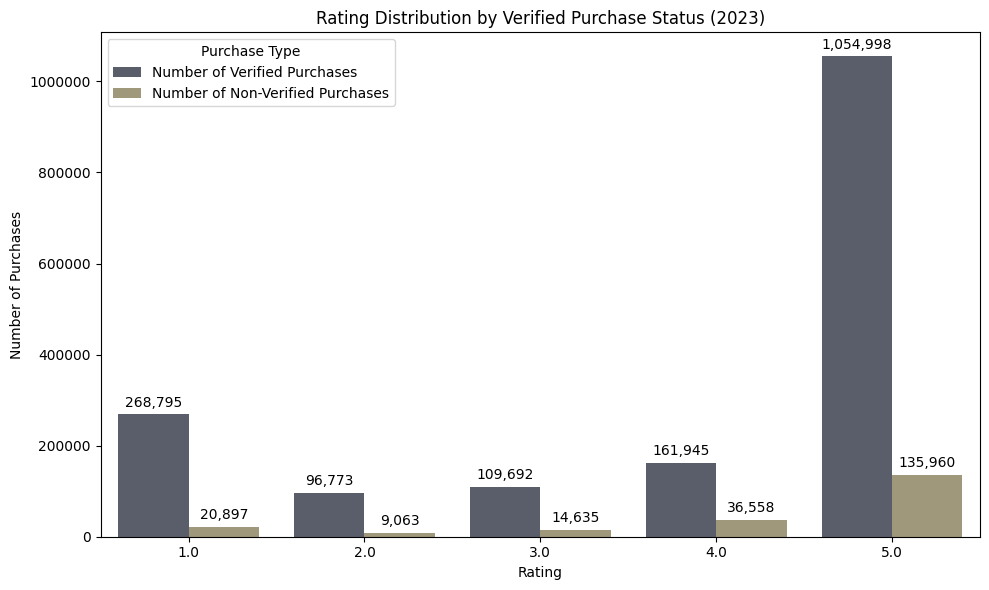

In [47]:
# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
plt.ticklabel_format(style='plain', axis='y') # Disable scientific notation

ax = sns.barplot(
    data=vp_dist_2023_melt,
    x='rating',
    y='Count',
    hue='Purchase Type',
    palette='cividis'
)

# Add value labels on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(vp_dist_2023_melt['Count']) * 0.01,
            f'{int(height):,}',
            ha='center',
            va='bottom',
        )

# Chart formatting
plt.title('Rating Distribution by Verified Purchase Status (2023)')
plt.xlabel('Rating')
plt.ylabel('Number of Purchases')
plt.tight_layout()
plt.savefig('segmentation_visuals/2023_rating_distribution')
plt.show()

- It appears that product reviewers tend to gravitate to the extremes when rating Electronics products on Amazon.
- The numbers may be a reflection of how Amazon screens and removes fake reviews, showing that their focus is on 1 star reviews instead of 5 star reviews.
- Alternatively, it could also mean that users are most likely to leave reviews on (Electronics) products when they are very satisfied or displeased with the product experience.

### 2023 Most Popular Products

In [48]:
# Store the query
product_popularity = joined_table\
    .filter(
        (F.year('datetime') == 2023) &
        (F.col('verified_purchase') == 'true')
    )\
    .groupBy(
        'parent_asin',
        'product_name',
        F.year('datetime').alias('year'),
        'avg_product_rating'
    )\
    .agg(F.count('*').alias('Review Counts'))\
    .orderBy(F.col('Review Counts').desc())\
    .limit(20)\

# Convert to Pandas DataFrame
product_popularity = product_popularity.toPandas()

# Truncate long product names
product_popularity['product_name'] = product_popularity['product_name'].apply(
    lambda x: x[:37] + '...' if isinstance(x, str) and len(x) > 40 else x
)

# Sort by review count
product_popularity = product_popularity.sort_values('Review Counts', ascending=False)

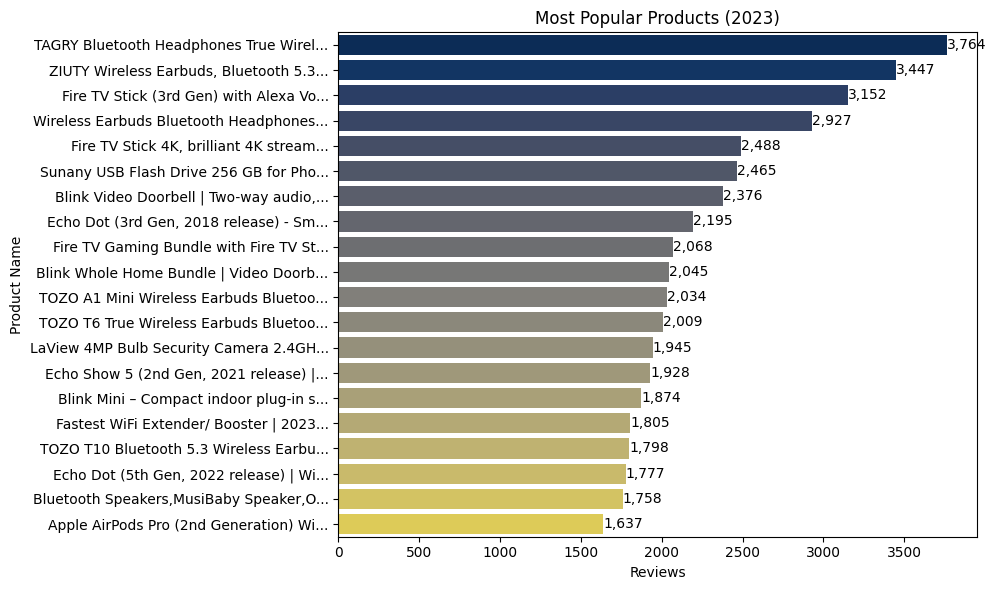

In [49]:
# Set plot style
plt.figure(figsize=(10, 6))

# Create the barplot
ax = sns.barplot(
    x='Review Counts',
    y='product_name',
    hue='product_name',
    data=product_popularity,
    palette='cividis',
    legend=False
)

# Add labels on bars
for i in ax.patches:
    width = i.get_width()
    ax.text(
        width,
        i.get_y() + i.get_height() / 2,
        f'{int(width):,}',
        va='center'
    )

# Set labels and title
plt.xlabel('Reviews')
plt.ylabel('Product Name')
plt.title('Most Popular Products (2023)')
plt.tight_layout()
plt.savefig('segmentation_visuals/2023_rating_distribution')
plt.show()

- The most popular products seem to be small electronics, especially earbuds.
- Other notable products are Fire products, Echo products, and cameras.

# Close the SparkSession

In [50]:
# Stop the SparkSession
spark.stop()

# Conclusion

As the data was scraped, there may be some issues with the scraping process, which included books in the data.

Memory cards and bluetooth audio devices are extremely popular. Amazon could try to tap into the demand for these items by developing their own Amazon Basics versions of these. 

If Amazon already has their own brand of such products, an investigation into why they aren't selling as well as products by other brands should be conducted. For example, how does sound quality and connectivity compare with other brands? Or how do read and write speeds compare to memory cards from other brands?

Echo Dots and Fire TV Sticks are still popular and should continue to be developed. 